# 1) Linear Plot with Normal Error

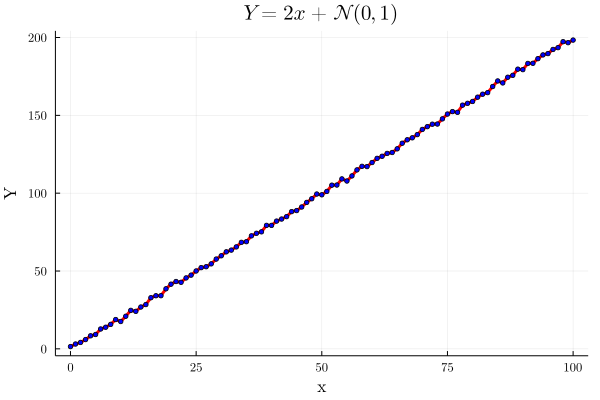

In [9]:
using Plots, LaTeXStrings
Plots.default(fontfamily="Computer Modern", lw=3)

x = collect(0:100)
y = 2x + randn(101)
plot(x, y, xlabel="x", ylabel="Y", title=L"Y = 2x + \mathcal{N}(0, 1)", color=:red, legend=false)
scatter!(x, y, ms=2.5, color=:blue)

# 2) Factorial!

In [12]:
factorial(x) = (x ≥ 0 && isinteger(x)) ? reduce(*, 1:Int(x); init=1) : error("your input variable is not valid")

factorial (generic function with 1 method)

In [13]:
factorial(5)

120

In [14]:
factorial(0)

1

In [15]:
factorial(-4)

LoadError: your input variable is not valid

In [16]:
factorial(2.5)

LoadError: your input variable is not valid

# 3) Predict who will have a Car Accident with Logistic Regression
## Processing the Data

In [1]:
using Flux, DataFrames, CSV
df = CSV.read("dataset.csv", DataFrame)

,interviewee ID,Region,Sex,Age,Car accident
,Int64,String1,String7,Float64?,Int64
1,1,C,female,18.0,0
2,2,C,female,18.0,0
3,3,B,male,18.0,0
4,4,C,male,18.0,0
5,5,C,male,18.0,1
6,6,B,male,18.0,0
7,7,A,female,18.0,1
8,8,C,male,18.0,0
9,9,B,male,18.0,0


In [2]:
using Statistics: mean, std
df.Age[ismissing.(df.Age)] .= mean(df.Age[.!ismissing.(df.Age)])

177-element view(::SentinelArrays.SentinelVector{Float64, Float64, Missing, Vector{Float64}}, [588, 589, 590, 591, 592, 593, 594, 595, 596, 597  …  755, 756, 757, 758, 759, 760, 761, 762, 763, 764]) with eltype Union{Missing, Float64}:
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
  ⋮
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458
 32.75127768313458

In [3]:
# one-hot encode regions
region = (unique(df.Region) .== permutedims(df.Region))
sex = permutedims(df.Sex .== "female")

1×764 BitMatrix:
 1  1  0  0  0  0  1  0  0  1  0  0  1  …  0  0  0  0  0  0  1  0  1  0  0  1

In [4]:
xs = Matrix{Float32}(vcat(region, sex, permutedims(df.Age)))
ys = permutedims(df."Car accident")

# Normalization
xs .-= mean(xs, dims=2)
xs ./= std(xs, dims=2)

5×764 Matrix{Float64}:
  0.93104    0.93104   -1.07266    0.93104   …   0.93104       0.93104
 -0.512314  -0.512314   1.94937   -0.512314     -0.512314     -0.512314
 -0.587042  -0.587042  -0.587042  -0.587042     -0.587042     -0.587042
  1.39953    1.39953   -0.713592  -0.713592     -0.713592      1.39953
 -1.52536   -1.52536   -1.52536   -1.52536      -1.98379e-14  -1.98379e-14

In [5]:
test_set_percentage = 15

test_set_indices = rand(1:nrow(df), Int(round(test_set_percentage / 100 * nrow(df))))
train_set_indices = setdiff(1:nrow(df), test_set_indices)

xtest, ytest = xs[:, test_set_indices], ys[:, test_set_indices]
xtrain, ytrain = xs[:, train_set_indices], ys[:, train_set_indices]

([0.9310395119946314 0.9310395119946314 … 0.9310395119946314 0.9310395119946314; -0.5123142837330874 -0.5123142837330874 … -0.5123142837330874 -0.5123142837330874; … ; 1.3995260775022562 1.3995260775022562 … -0.7135923478173559 1.3995260775022562; -1.5253570955539968 -1.5253570955539968 … -1.9837907283773496e-14 -1.9837907283773496e-14], [0 0 … 0 0])

## Training

In [6]:
model = Flux.Dense(5 => 1, σ)
loss(x, y) = Flux.binarycrossentropy(model(x), y)
optimiser = Flux.Descent()
parameters = Flux.params(model)

Params([Float32[0.75950634 0.4453913 … 0.80046046 -0.29945445], Float32[0.0]])

In [7]:
loss(xtrain, ytrain)

0.8109809370733476

In [8]:
for _ in 1:10000
    Flux.train!(loss, parameters, [(xtrain, ytrain)], optimiser)
end

In [9]:
loss(xtrain, ytrain)

0.4299001908132878

In [36]:
predictions = model(xtest) .> 0.5

predicted_positives = sum(predictions)
predicted_negatives = length(predictions) - predicted_positives
actual_positives = sum(ytest)
actual_negatives = length(ytest) - actual_positives

true_positives = sum(predictions .& ytest)
false_positives = predicted_positives - true_positives
true_negatives = sum(.~predictions .& .~ytest)
false_negatives = predicted_negatives - true_negatives

precision = true_positives / predicted_positives
recall = true_positives / actual_positives
f1_score = 2 * precision * recall / (precision + recall)

println("True Positives = $true_positives\nTrue Negatives = $true_negatives\n"
    * "False Positives = $false_positives\nFalse Negatives = $false_negatives\n")
println("Precision = $precision\n"
    * "Recall = $recall\n"
    * "F1 Score = $f1_score")

True Positives = 32
True Negatives = 60
False Positives = 8
False Negatives = 15

Precision = 0.8
Recall = 0.6808510638297872
F1 Score = 0.7356321839080461
